In [53]:
import torch

In [54]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))
print(torch.cuda.memory_allocated(0))
print(torch.cuda.memory_cached())

True
0
GeForce GTX 1650
6550016
48234496


D:\Anaconda\envs\hello\lib\site-packages\torch\cuda\memory.py:344: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [55]:
!python -V

Python 3.8.10


In [56]:
INPUT_SHAPE = (512,1024,3)

In [57]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")  

GPU


In [58]:
import cv2
import torch
import torch.nn
import numpy as np
import pandas as pd
from torch.optim import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import os

#### Function to load the file

In [59]:
def load_data(path):
  data = pd.read_csv(path)
  data = data[data['Speed'] != 'Speed']
  data.drop(['Unnamed: 0'],axis = 1,inplace = True)
  data.info()
  X = data[['Left','Right']].values
  y = data[['Steering_angle','Speed']].values.astype(np.float)
 
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
  print(X_train.shape)
  print(y_train.shape)
  print(X_valid.shape)
  print(y_valid.shape)
  return X_train, X_valid, y_train, y_valid

In [60]:
path = "data_final.csv"
X_train_dummy, X_valid_dummy, y_train_dummy, y_valid_dummy = load_data(path)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14318 entries, 0 to 14321
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Left            14318 non-null  object
 1   Right           14318 non-null  object
 2   Steering_angle  14318 non-null  object
 3   Speed           14318 non-null  object
dtypes: object(4)
memory usage: 559.3+ KB
(11454, 2)
(11454, 2)
(2864, 2)
(2864, 2)


(512, 1024, 3)


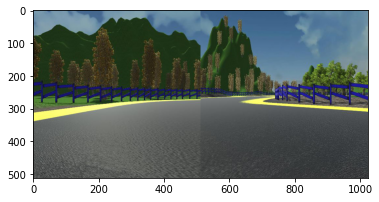

In [61]:
i = 1344
left = X_train_dummy[i][0] 
right = X_train_dummy[i][1] 
image = conc(left,right)
print(image.shape)
plt.imshow(image)

# Data Augmentation

#### Function to load the image

In [62]:
def load_image(path):
    return mpimg.imread(path)

#### Function to concatenate the images horizontally.

In [63]:
def conc(img1_path,img2_path):
  img1 = load_image(img1_path)
  img2 = load_image(img2_path)
  im_h = cv2.hconcat([img1, img2])
  return im_h

#### Function to grayscale the images.

In [64]:
def preprocess(image):
    img = np.mean(image, axis=2) / 255
    return img.reshape(INPUT_SHAPE[0],INPUT_SHAPE[1],1)

#### Function to Flip the images.

In [65]:
def random_flip(image, steering_angle):
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

#### Function for augmentation of the images


In [66]:
def augument(left, right, steering_angle, speed, range_x=100, range_y=10):
    im_h = conc(left,right)
    im_h_grayscale = preprocess(im_h)
    image, steering_angle = random_flip(im_h_grayscale, steering_angle)
    return image.reshape(INPUT_SHAPE[0],INPUT_SHAPE[1],1), steering_angle, speed

#### Function to generate Batch of the images

In [67]:
def batch_generator(image_paths, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, INPUT_SHAPE[0], INPUT_SHAPE[1], 1])
    steers = np.empty(batch_size)
    speeds = np.empty(batch_size)
    i = 0
    for index in np.random.permutation(image_paths.shape[0]):
        left, right = image_paths[index]
        steering_angle, speed = steering_angles[index]
        if is_training and np.random.rand() < 0.6:
            image, steering_angle, speed = augument(left, right, steering_angle,speed)
        else:
            image = preprocess(conc(left,right))
        # add the image and steering angle to the batch
        images[i % batch_size] = image
        steers[i % batch_size] = steering_angle
        speeds[i % batch_size] = speed
        i += 1
        if i % batch_size == 0:
            yield images, steers, speeds
            images = np.empty([batch_size, INPUT_SHAPE[0], INPUT_SHAPE[1], 1])
            steers = np.empty(batch_size)
            speeds = np.empty(batch_size)

## Building and training the model

In [72]:
# def build_model():
#     model = torch.nn.Sequential(
#         torch.nn.AvgPool2d(kernel_size = (3,3),stride = (2,2)),
#         torch.nn.Conv2d(in_channels = 1, out_channels = 24,kernel_size = (7,7), stride = (2,2)),
#         torch.nn.ELU(),
#         torch.nn.BatchNorm2d(24),
#         torch.nn.Conv2d(in_channels=24, out_channels=36, kernel_size=(7,7), stride=(2, 2)),
#         torch.nn.ELU(),
#         torch.nn.BatchNorm2d(36),
#         torch.nn.Conv2d(in_channels=36, out_channels=48, kernel_size=(5, 5), stride=(2, 2)),
#         torch.nn.ELU(),
#         torch.nn.BatchNorm2d(48),
#         torch.nn.Conv2d(in_channels=48, out_channels=64, kernel_size=(3,3), stride=(2,2)),
#         torch.nn.ELU(),
#         torch.nn.BatchNorm2d(64),
#         torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(2,2)),
#         torch.nn.ELU(),
#         torch.nn.BatchNorm2d(64),
#         torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1)),
#         torch.nn.ELU(),
#         torch.nn.BatchNorm2d(64), 
#         torch.nn.Dropout(p=0.5, inplace=False),
#         torch.nn.Flatten(),
#         torch.nn.Linear(in_features = 3072, out_features = 200,bias = True),
#         torch.nn.ELU(),

# #         torch.nn.Linear(in_features = 600,out_features = 200,bias = True),
# #         torch.nn.ELU(),
#         torch.nn.Linear(in_features = 200,out_features = 50,bias = True),
#         torch.nn.ELU(),
#         torch.nn.Dropout(p=0.2, inplace=False),
#         torch.nn.Linear(in_features = 50,out_features = 10,bias = True),
#         torch.nn.ELU(),
#         torch.nn.Linear(in_features = 10,out_features = 2,bias = True)
#     )

#     return model.to(device)

In [68]:
class Net(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.avg = torch.nn.AvgPool2d(kernel_size = (3,3),stride = (2,2))
            self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 24,kernel_size = (7,7), stride = (2,2))  
            self.bn1 = torch.nn.BatchNorm2d(24)
            self.elu = torch.nn.ELU()
            self.conv2 = torch.nn.Conv2d(in_channels=24, out_channels=36, kernel_size=(7,7), stride=(2, 2))  
            self.bn2 = torch.nn.BatchNorm2d(36)
            torch.nn.ELU()
            self.conv3 = torch.nn.Conv2d(in_channels=36, out_channels=48, kernel_size=(5, 5), stride=(2, 2))
            self.bn3 = torch.nn.BatchNorm2d(48)
            torch.nn.ELU()
            self.conv4 = torch.nn.Conv2d(in_channels=48, out_channels=64, kernel_size=(3,3), stride=(2,2))
            self.bn4 = torch.nn.BatchNorm2d(64)
            torch.nn.ELU()
            self.conv5 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(2,2))  
            self.bn5 = torch.nn.BatchNorm2d(64)
            torch.nn.ELU()
            self.conv6 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1))  
            self.bn6 = torch.nn.BatchNorm2d(64)
            torch.nn.ELU()
            
            self.dropout = torch.nn.Dropout(p=0.5)
            self.linear1 = torch.nn.Linear(3072, 200)
            torch.nn.ELU()
            self.linear2 = torch.nn.Linear(200, 50)
            torch.nn.ELU()
            self.linear3 = torch.nn.Linear(50,10)
            torch.nn.ELU()
            self.linear4 = torch.nn.Linear(10,2)
            
        def forward(self,x):
            x = self.avg(x)
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.elu(x)
            x = self.conv2(x)
            x = self.bn2(x)
            x = self.elu(x)
            x = self.conv3(x)
            x = self.bn3(x)
            x = self.elu(x)
            x = self.conv4(x)
            x = self.bn4(x)
            x = self.elu(x)
            x = self.conv5(x)
            x = self.bn5(x)
            x = self.elu(x)
            x = self.conv6(x)
            x = self.bn6(x)
            x = self.elu(x)
           
            x = x.reshape(-1,3072)
            x = self.linear1(x)
            x = self.elu(x)
            x = self.linear2(x)
            x = self.elu(x)
            x = self.linear3(x)
            x = self.elu(x)
            x = self.linear4(x)
            return x

In [69]:
from torchsummary import summary

In [70]:
model = Net()
model = model.to(device)

In [71]:
summary(model,input_size = (1,512,1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         AvgPool2d-1          [-1, 1, 255, 511]               0
            Conv2d-2         [-1, 24, 125, 253]           1,200
       BatchNorm2d-3         [-1, 24, 125, 253]              48
               ELU-4         [-1, 24, 125, 253]               0
            Conv2d-5          [-1, 36, 60, 124]          42,372
       BatchNorm2d-6          [-1, 36, 60, 124]              72
               ELU-7          [-1, 36, 60, 124]               0
            Conv2d-8           [-1, 48, 28, 60]          43,248
       BatchNorm2d-9           [-1, 48, 28, 60]              96
              ELU-10           [-1, 48, 28, 60]               0
           Conv2d-11           [-1, 64, 13, 29]          27,712
      BatchNorm2d-12           [-1, 64, 13, 29]             128
              ELU-13           [-1, 64, 13, 29]               0
           Conv2d-14            [-1, 64

In [72]:
np.random.seed(0)
training_loss = []
validation_loss = []
batch_size = 30

def train_model(model,X_train, X_valid, y_train, y_valid):
    """
    Train the model
    """
    criterion = torch.nn.MSELoss(reduction = 'none')

    optimizer = Adam(model.parameters(),lr =1.0e-4)
    targets = torch.randn(batch_size, 2).to(device)
    for epoch in range(50):
        running_loss = 0
        total_loss_valid = 0
        model.train()
        total_loss = 0
        i = 0
        print('Epoch : {}'.format(epoch + 1))
        print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
        for imgs,steers,speeds in batch_generator(X_train, y_train, batch_size = 30, is_training = True):

            shape_imgs = imgs.shape
            imgs = imgs.reshape(shape_imgs[0],shape_imgs[3],shape_imgs[1],shape_imgs[2])
            imgs = torch.cuda.FloatTensor(imgs)
#             imgs = imgs.to(device)
            steers = steers.reshape(batch_size,1)
            steers = torch.cuda.FloatTensor(steers)
#             steers = steers.to(device)
            speeds = speeds.reshape(batch_size,1)
            speeds = torch.cuda.FloatTensor(speeds)
#             speeds = speeds.to(device)
            
             
            for k in range(batch_size):
                targets[k][0] = steers[k]
                targets[k][1] = speeds[k]
            
            outputs = model(imgs)
            targets.to(device)
            optimizer.zero_grad()
            loss = torch.mean(criterion(outputs, targets.to(device)))
            loss.backward()
            optimizer.step()
            i = i + 1
            running_loss += loss.item()
            del loss

            # print statistics
            if i % 5 == 0:  # print every 5 mini-batches
                print('The training loss: %.6f after %d' % (running_loss / (i),i))

        running_loss = running_loss / (X_train.shape[0]  / 30)
        
        


        model.eval()


        j = 0
        
        for imgs, steers,speeds in batch_generator(X_valid, y_valid,  batch_size = 30,is_training = False):
            
            shape_imgs = imgs.shape
            imgs = imgs.reshape(shape_imgs[0],shape_imgs[3],shape_imgs[1],shape_imgs[2])
            imgs = torch.cuda.FloatTensor(imgs)
#             imgs = imgs.to(device)
            steers = steers.reshape(batch_size,1)
            steers = torch.cuda.FloatTensor(steers)
#             steers = steers.to(device)
            speeds = speeds.reshape(batch_size,1)
            speeds = torch.cuda.FloatTensor(speeds)
#             speeds = speeds.to(device)

            
            for l in range(batch_size):
                targets[l][0] = steers[l]
                targets[l][1] = speeds[l]
            
            outputs = model(imgs)
            targets.to(device)
            optimizer.zero_grad()
            loss = torch.mean(criterion(outputs, targets.to(device)))
            loss.backward()
            optimizer.step()
            j = j + 1
            total_loss_valid += loss.item()
            if j % 5 == 0:  # print every 5 mini-batches
                print('The Validation loss: %.6f after %d' % (total_loss_valid / (j), j))

        total_loss_valid = total_loss_valid / (X_valid.shape[0] / 30)

        training_loss.append(running_loss)
        
        path = os.path.join("models/",'model{}.pt'.format(epoch +1))
        torch.save(model,path)
        
        print('The training loss after epoch{} is {}'.format(epoch,(running_loss)))
        validation_loss.append(total_loss_valid)
        print('The validation loss after epoch{} is {}'.format(epoch, total_loss_valid))

def main():
    print('-' * 30)
    print('Parameters')
    print('-' * 30)
    print('test_size_split = 0.2')
    print('keep_prob = 0.5')
    print('nb_epoch = 50')
    print('batch_size = 30')
    print('learning_rate = 0.0001')
    print('-' * 30)

    path = 'data_final.csv'
    X_train, X_valid, y_train, y_valid = load_data(path)
    model = Net()
    model = model.to(device)
    train_model(model,X_train, X_valid, y_train, y_valid)

#     torch.save(model, 'model.pt')
    



    
if __name__ == '__main__':
    main()

------------------------------
Parameters
------------------------------
test_size_split = 0.2
keep_prob = 0.5
nb_epoch = 50
batch_size = 30
learning_rate = 0.0001
------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14318 entries, 0 to 14321
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Left            14318 non-null  object
 1   Right           14318 non-null  object
 2   Steering_angle  14318 non-null  object
 3   Speed           14318 non-null  object
dtypes: object(4)
memory usage: 559.3+ KB
(11454, 2)
(11454, 2)
(2864, 2)
(2864, 2)
Epoch : 1
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
The training loss: 702.743835 after 5


KeyboardInterrupt: 

In [ ]:
max(training_loss)

In [86]:
min(training_loss)

18.365059266107878

In [14]:
min(validation_loss)

10.958123328632482

In [15]:
max(validation_loss)

57.048060953950085

In [3]:
training_loss = [168.85318087682228, 62.10586815619731, 54.56521836046525, 49.381798184186515, 47.10000310910816, 44.9617351743799, 43.40977689244473, 41.231475078728636, 40.60436895719182, 39.33352642748729, 38.371237989118924, 37.67509018332, 36.61498803627809, 35.43540995554377, 35.33945923391095, 34.72123512989442, 34.165159383327186, 33.14590199571932, 32.589962026597064, 32.13329665632133, 31.215794050237655, 30.42416028042249, 29.71797059130581, 29.52085803478035, 28.983876918734772, 28.788088865464992, 27.553548395727365, 27.3876984722643, 27.129049890637084, 26.145708934370294, 26.046617639320818, 25.661887265800367, 24.67522761033679, 24.230425026855148, 23.85785194764654, 23.818328696561146, 22.99333867382291, 22.514109114441588, 22.182228044416966, 21.54373293087831, 21.7065307243511, 21.0193326474485, 20.55154939045014, 20.095989660419924, 20.113747251040028, 19.94563861315384, 19.129151181440317, 19.00617707268988, 18.49055133108196, 18.365059266107878]

In [4]:
validation_loss = [57.048060953950085, 48.9607331806055, 45.25157346405796, 40.615164860666795, 38.81627370525339, 36.16606089655913, 33.43817195412833, 31.87769175907753, 31.288635354468276, 29.99680332631372, 28.404247237983363, 27.59277531887566, 26.366494171446263, 25.922014516825115, 25.011920908975867, 23.847784256801923, 23.730177073505338, 22.607498661765838, 22.05417881131838, 21.58441415712154, 21.09067408066222, 19.97443131228399, 19.28777771289122, 19.12534939843183, 18.431193840237302, 18.26673893955167, 17.660680007002206, 16.741872746185216, 16.83942925330647, 16.272415247376404, 15.970828370009054, 15.50114317812733, 15.40799318578656, 14.78102457090463, 14.406708172579718, 14.268811166952442, 14.02392988431387, 14.103831602208441, 13.403719721892692, 13.531455326013724, 12.99960268775844, 13.052804348522058, 12.720935376329795, 12.223641452842584, 12.107843916509404, 11.993071875592184, 11.891118798342497, 11.469418438120261, 11.005264430738693, 10.958123328632482]

In [5]:
print(training_loss)

[168.85318087682228, 62.10586815619731, 54.56521836046525, 49.381798184186515, 47.10000310910816, 44.9617351743799, 43.40977689244473, 41.231475078728636, 40.60436895719182, 39.33352642748729, 38.371237989118924, 37.67509018332, 36.61498803627809, 35.43540995554377, 35.33945923391095, 34.72123512989442, 34.165159383327186, 33.14590199571932, 32.589962026597064, 32.13329665632133, 31.215794050237655, 30.42416028042249, 29.71797059130581, 29.52085803478035, 28.983876918734772, 28.788088865464992, 27.553548395727365, 27.3876984722643, 27.129049890637084, 26.145708934370294, 26.046617639320818, 25.661887265800367, 24.67522761033679, 24.230425026855148, 23.85785194764654, 23.818328696561146, 22.99333867382291, 22.514109114441588, 22.182228044416966, 21.54373293087831, 21.7065307243511, 21.0193326474485, 20.55154939045014, 20.095989660419924, 20.113747251040028, 19.94563861315384, 19.129151181440317, 19.00617707268988, 18.49055133108196, 18.365059266107878]


In [6]:
print(validation_loss)

[57.048060953950085, 48.9607331806055, 45.25157346405796, 40.615164860666795, 38.81627370525339, 36.16606089655913, 33.43817195412833, 31.87769175907753, 31.288635354468276, 29.99680332631372, 28.404247237983363, 27.59277531887566, 26.366494171446263, 25.922014516825115, 25.011920908975867, 23.847784256801923, 23.730177073505338, 22.607498661765838, 22.05417881131838, 21.58441415712154, 21.09067408066222, 19.97443131228399, 19.28777771289122, 19.12534939843183, 18.431193840237302, 18.26673893955167, 17.660680007002206, 16.741872746185216, 16.83942925330647, 16.272415247376404, 15.970828370009054, 15.50114317812733, 15.40799318578656, 14.78102457090463, 14.406708172579718, 14.268811166952442, 14.02392988431387, 14.103831602208441, 13.403719721892692, 13.531455326013724, 12.99960268775844, 13.052804348522058, 12.720935376329795, 12.223641452842584, 12.107843916509404, 11.993071875592184, 11.891118798342497, 11.469418438120261, 11.005264430738693, 10.958123328632482]


In [10]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1,51), y=training_loss,
                    mode='lines',
                    name='Training Loss'))
fig.add_trace(go.Scatter(x=np.arange(1,51), y=validation_loss,
                    mode='lines+markers',
                    name='Validation Loss'))
# fig.add_trace(go.Scatter(x=random_x, y=random_y2,
#                     mode='markers', name='markers'))

fig.show()

In [12]:
torch.cuda.empty_cache()

In [13]:
 torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |